# MODEL

In [ ]:
# por si aca
# !pip install scikit-learn --upgrade

In [10]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt


from sklearn import preprocessing
from sklearn.preprocessing import KBinsDiscretizer , StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline , Pipeline
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from scipy import stats
from scipy.special import boxcox, inv_boxcox


%matplotlib inline

# read in the csv files
type_1 = pd.read_csv('data/amount_type_1.csv').drop(columns = 'user id')
type_2 = pd.read_csv('data/amount_type_2.csv').drop(columns = 'user id')
type_3 = pd.read_csv('data/amount_type_3.csv').drop(columns = 'user id')

# clear outsiders

In [2]:
def clear_outsiders (df , col , max_offer):
    '''
    drop outsiders
    IMPUT:
        df (dataFrame) - data to be modify
        col (str) - name of the column that has NaN values to clear
        max_offer (int) -   maximum value spected in a transaction influenced by an offer 
                            (e.g. someone that spend more than 1000$ it's unlikely that was influenced by an offer)
    OUTPUT:
        df (dataFrame) without outsiders
    '''  
    #remove values > max_offer
    df = df.drop(df[df[col] > max_offer ].index)
    
    #round values
    df[col] = (df[col] * 10).round(0)
    df = df.astype(int)
    
    #removing value 0
    df = df.drop(df[df[col] == 0 ].index)
    
    return df

# Bucketize

In [3]:
def bucketizer(df , col, bins=10):
    '''
    Create buckets for a column
    IMPUT:
        df (dataFrame) - data to be modify
        col (str) - name of the column to be bucketize
        bins (int) - number of bins to be created
    OUTPUT:
        values_pp (Series) Serie of the bucketize column
    '''
    values_np = df[col].values.reshape(-1,1)
    bucketizer =  KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='uniform').fit(values_np)
    values_pp = bucketizer.transform(values_np)
    
    return values_pp    

# SPLIT DATA  : TEST -TRAIN

In [4]:
def split_box_cox(df , lable):
    '''
    split data set into Train and Test and apply log (box-cox) to the y_Train to have a normal distribution of the data
    IMPUT:
        df (dataFrame)
        lable (str) - name of the label to be predicted
    OUTPUT:
        X_train, X_test  (dataFrame) split data Train - Test
        y_train_box, y_test (Series) split data Train - Test
        maxlog - (int) value of the lmbda parameter to reverse the applied log
    '''
    
    X = df.drop(columns = [lable])
    y = df[lable]

    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    box_train , maxlog = stats.boxcox(y_train)
    y_train_box = pd.Series(box_train)
    
    #plt.hist(y_train_box, bins = 100);
        
    return X_train, X_test, y_train_box, y_test , maxlog

In [5]:
def train_model (X_train , y_train):
    '''
    strain model
    IMPUT:
        X_train (dataFrame)
        y_train (series)
    OUTPUT:
        clf (Pipeline) fit model pipeline
    '''   
    
    clf = make_pipeline(SVR())
    clf.fit(X_train, y_train)
    
    return clf

def test_model (clf , X_test , y_test , maxlog , max_offer):
    '''
    test model
    IMPUT:
        clf (Pipeline)
        X_test (dataFrame)
        y_test (series)
        maxlog (int) - value of the lmbda parameter to reverse the applied log
        max_offer (int)
        
    OUTPUT: 
        y_pred (array) test prediction
        r2 (int) r^2 (coefficient of determination) 
    '''
    
    predictions = clf.predict(X_test)
    y_pred = inv_boxcox(predictions, maxlog)
    y_pred = np.nan_to_num(y_pred)  # in some cases inv_boxcox can return a NaN (when is a complex number)
    r2 = r2_score(y_test, y_pred)
   
    return y_pred , r2

# main

In [6]:
def model (df , lable , max_offer):
    '''
    create and train the model
    IMPUT:
        df (dataFrame) data set of for a type of offer
        lable (str) - name of the label to be predicted
        max_offer (int)
        
    OUTPUT: data to plot results
        y_train , y_test (Series)
        y_pred (array) test prediction 
        r2 (int) r^2 (coefficient of determination) 
        lable (str) - name of the label to be predicted
        max_offer (int)
    '''
    df = clear_outsiders (df , lable ,  max_offer)
    
    #bucketizer
    df['age'] = bucketizer(df , 'age' , 8)
    df['income'] = bucketizer(df , 'income' , 9)
    
    #split into train and test
    X_train, X_test, y_train, y_test , maxlog = split_box_cox(df , lable)
    
    clf = train_model (X_train , y_train)
    y_pred , r2 = test_model (clf , X_test , y_test , maxlog , max_offer )
    
    return y_train , y_test , y_pred , r2 , lable , max_offer 

In [7]:
def print_results(y_train , y_test , y_pred , r2 , lable , max_offer):
    '''
    print results
    IMPUT:
        y_train , y_test (Series)
        y_pred (array) test prediction 
        r2 (int) r^2 (coefficient of determination) 
        lable (str) - name of the label to be predicted
        max_offer (int)
        
    OUTPUT: no output  
    '''
    
    #plt.hist(y_train_box, bins = 100);
    
    mu = y_train.mean()  # mean of distribution
    sigma = np.std(y_train)  # standard deviation of distribution
    
    num_bins = 100
    f1, ax1 = plt.subplots()

    n, bins, patches = ax1.hist(y_train, num_bins, density=1)

    # add a 'best fit' line
    y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
         np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
    ax1.plot(bins, y, '--')
    ax1.set_xlabel('amount transaction ($) - label data')
    ax1.set_ylabel('Number of users')
    ax1.set_title('data to be trained - checking if its a normal distribution')

    # Tweak spacing to prevent clipping of ylabel
    f1.tight_layout()
    plt.show();
        
    print ('r2 score =' , r2)
    
    f2, ax2 = plt.subplots()
    ax2.plot(range(max_offer * 10))
    f2.suptitle(lable, fontsize=15)
    plt.xlabel('train values')
    plt.ylabel('prediction values')
    ax2.scatter(y_test.values , y_pred , s=10 , c='r')
    plt.show();

In [8]:
def train_and_plot (type_offer , lable , max_offer):
    '''
    train model and plot results for a given type of offer
    IMPUT:
        type_offer (dataFrame)
        lable (str) - name of the label to be predicted
        max_offer (int)
        
    OUTPUT: no output  
    '''
    
    y_train , y_test , y_pred , r2 , lable , max_offer = model(type_offer , lable , max_offer)
    print_results (y_train , y_test , y_pred , r2 , lable , max_offer)

#  model - type 1  - bogo

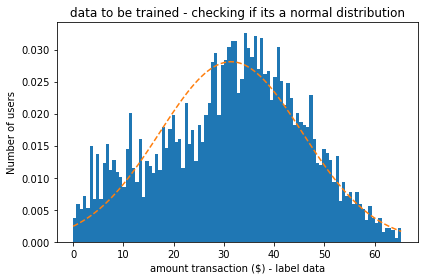

r2 score = 0.6815829606475411


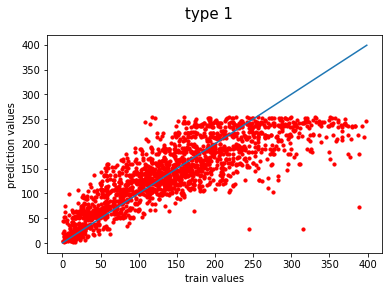

In [11]:
# type 1 bogo
train_and_plot (type_1 , 'type 1' , 40)

#  model - type 2  - Informational

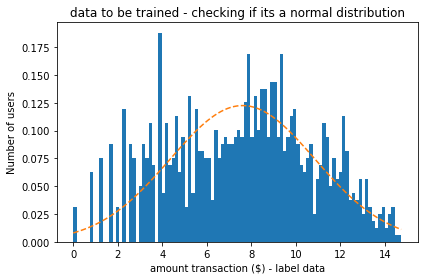

r2 score = 0.45797590407464683


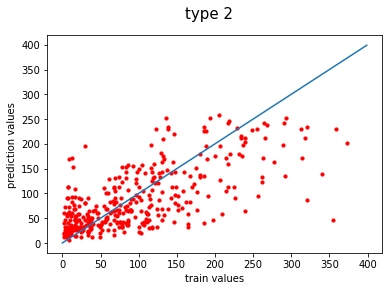

In [12]:
# type 2 Informational
train_and_plot (type_2 , 'type 2' , 40)

#  model - type 3  - Discount

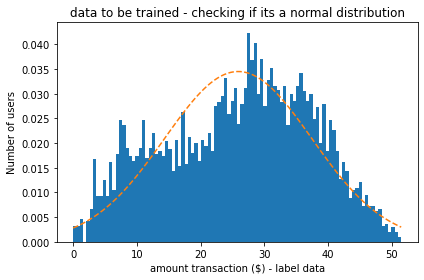

r2 score = 0.6748686603064886


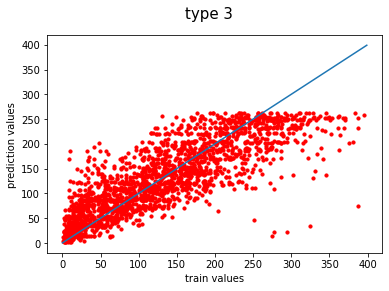

In [13]:
# type 3 Discount
train_and_plot (type_3 , 'type 3' , 40)

# Checking max offer value

In [14]:
r2_lst = []

for max_offer in range(1 , 500 , 5):
    y_train , y_test , y_pred , r2 , lable , max_offer = model(type_1 , 'type 1' , max_offer)
    r2_lst.append(r2)

KeyboardInterrupt: 

In [ ]:
t = range(1 , 500 , 5)

f3, ax3 = plt.subplots()
ax3.plot(t, r2_lst)
ax3.plot(np.linspace(40,40,5) , np.linspace(0,0.8,5))

ax3.set(xlabel='max offer ($)', ylabel='r2 error',
       title='max offer for a better r2 model result')
ax3.grid()

plt.show()